In [1]:
%load_ext autoreload
%autoreload 2

## Importing & Setting Style

In [169]:
# imports
import os, sys, string, re, itertools, random

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# # updates for nltk helper packages
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from src import visualizations as vz
from src import functions as fn

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## `dir` Check

In [66]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data & Checking Info

In [4]:
path = path = os.path.join(gparent, 'data/raw',\
                           'judge-1377884607_tweet_product_company.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Checking Null Tweet

In [6]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


## Dropping Null Tweet

In [7]:
df.drop(6, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Checking Nulls in Product Column

In [9]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [10]:
df[df['emotion_in_tweet_is_directed_at'].isnull()].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
15,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
31,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
32,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
33,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product


## Renaming Columns
The original names are a bit unwieldy.

In [11]:
rename_dict = {'tweet_text': 'tweet', 
               'emotion_in_tweet_is_directed_at': 'brand_product', 
               'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion' }
df.rename(columns=rename_dict, inplace=True)
df.head()

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking Brand/Product Unique Values

In [12]:
df.brand_product.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

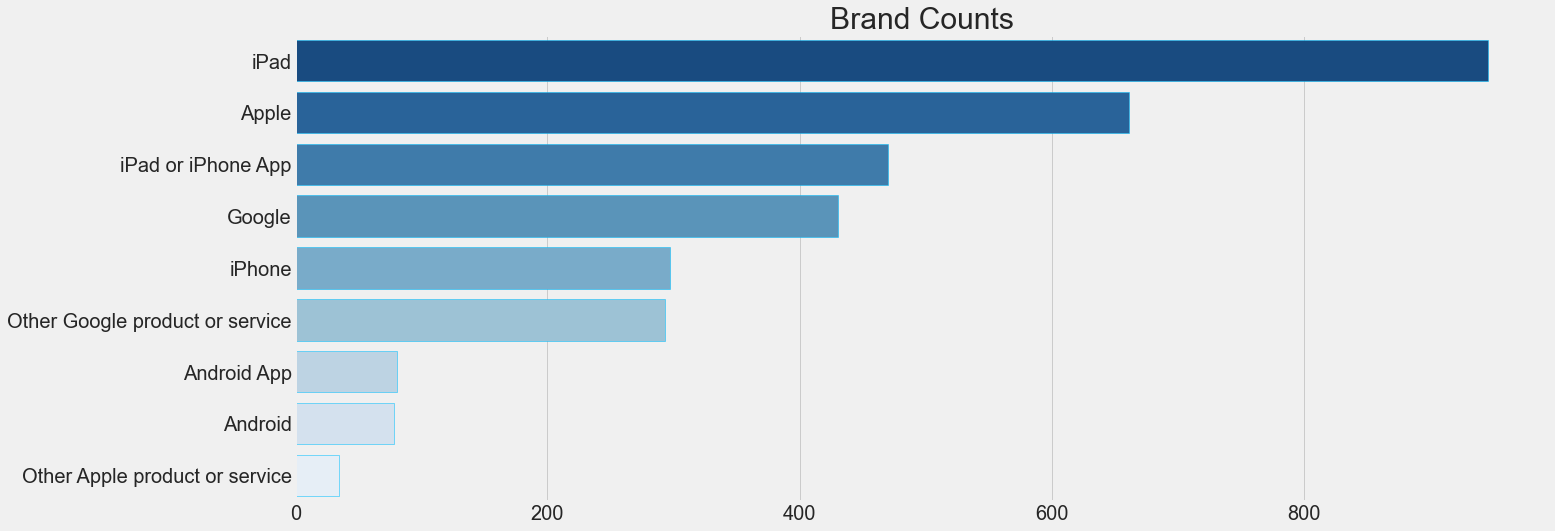

In [13]:
vz.brand_counts(df)

In [14]:
df.brand_product.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: brand_product, dtype: int64

In [15]:
df.brand_product.isna().sum()

5801

## Checking Emotion Unique Values

In [16]:
df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

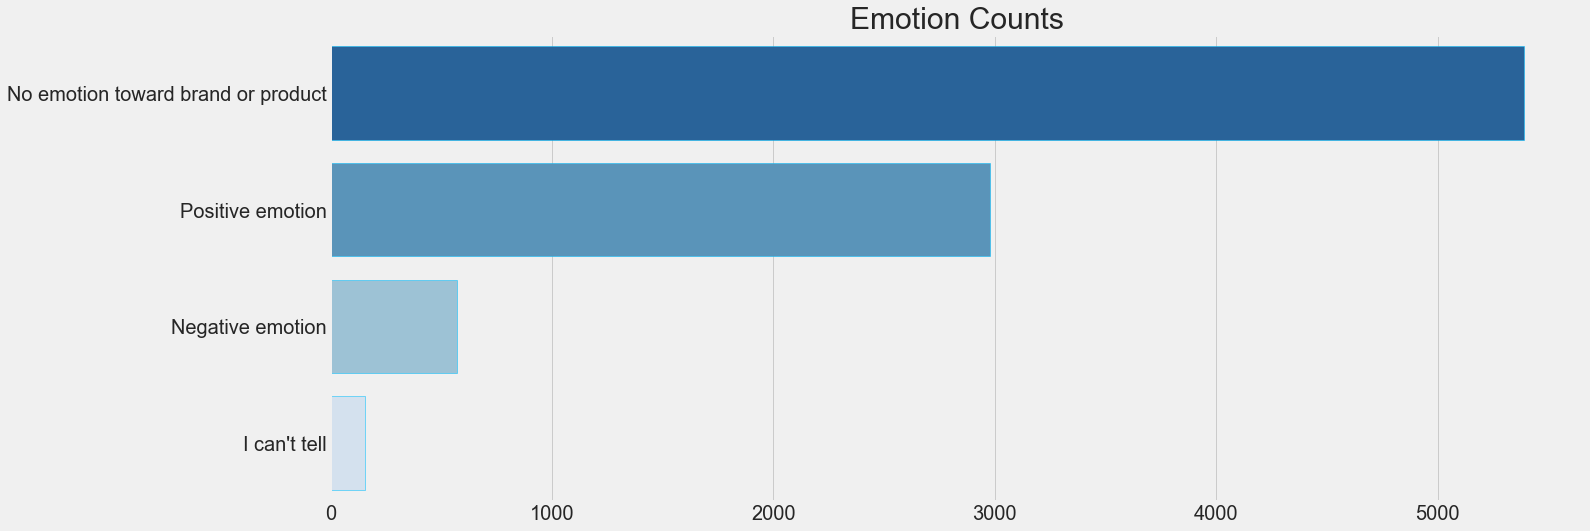

In [17]:
vz.emotion_counts(df)

In [18]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

## Emotions by Brand

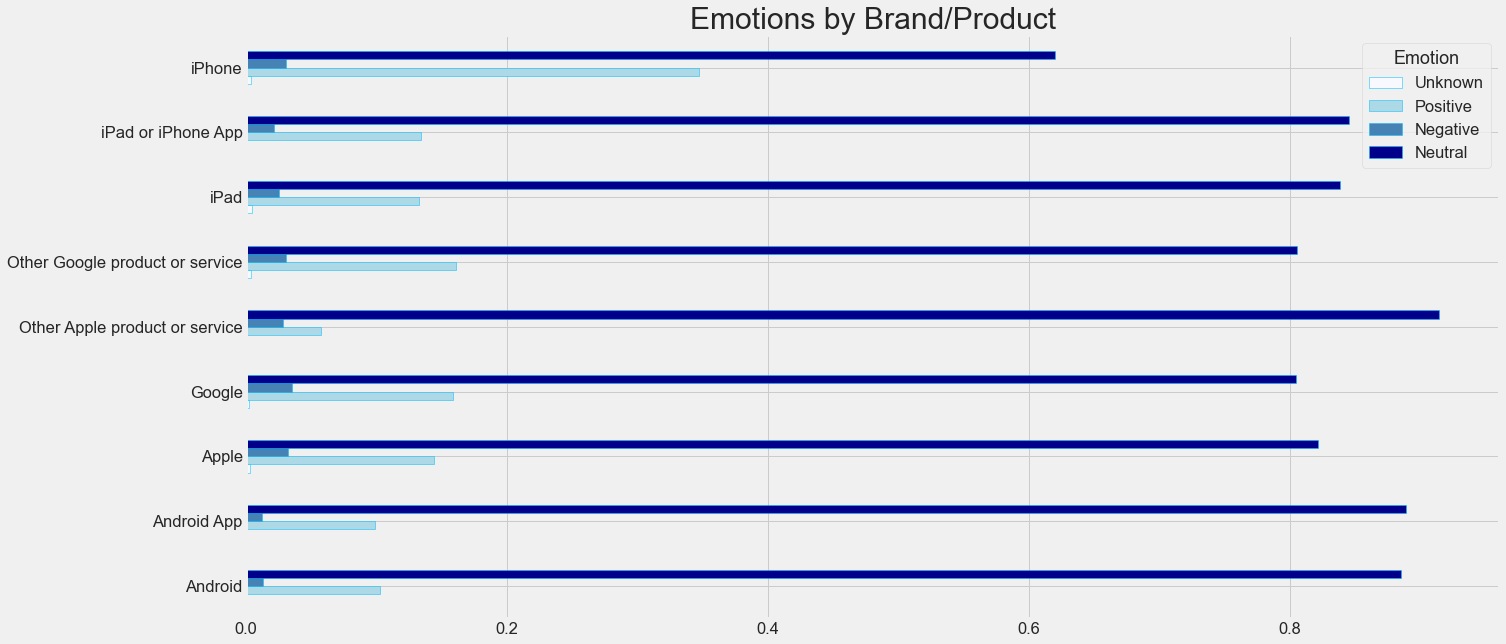

In [178]:
vz.brand_emotions(df)

## Checking Null Brands Emotion Data

In [19]:
null_brand_emotions = df[(df['brand_product'].isna()) &\
                        (df['emotion'] != 'No emotion toward brand or product')]

In [20]:
null_brand_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 45 to 9057
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          504 non-null    object
 1   brand_product  0 non-null      object
 2   emotion        504 non-null    object
dtypes: object(3)
memory usage: 15.8+ KB


In [21]:
null_brand_emotions.head()

,tweet,brand_product,emotion
45,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive emotion
63,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion
67,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative emotion
89,Thanks to @mention for publishing the news of ...,NaN,I can't tell
101,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell


## Examining Some Tweets

In [22]:
print(null_brand_emotions.tweet[45])

Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link}


In [23]:
print(null_brand_emotions.tweet[63])

Again? RT @mention Line at the Apple store is insane.. #sxsw


In [24]:
print(null_brand_emotions.tweet[67])

Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw


## Null Brand Emotion Counts

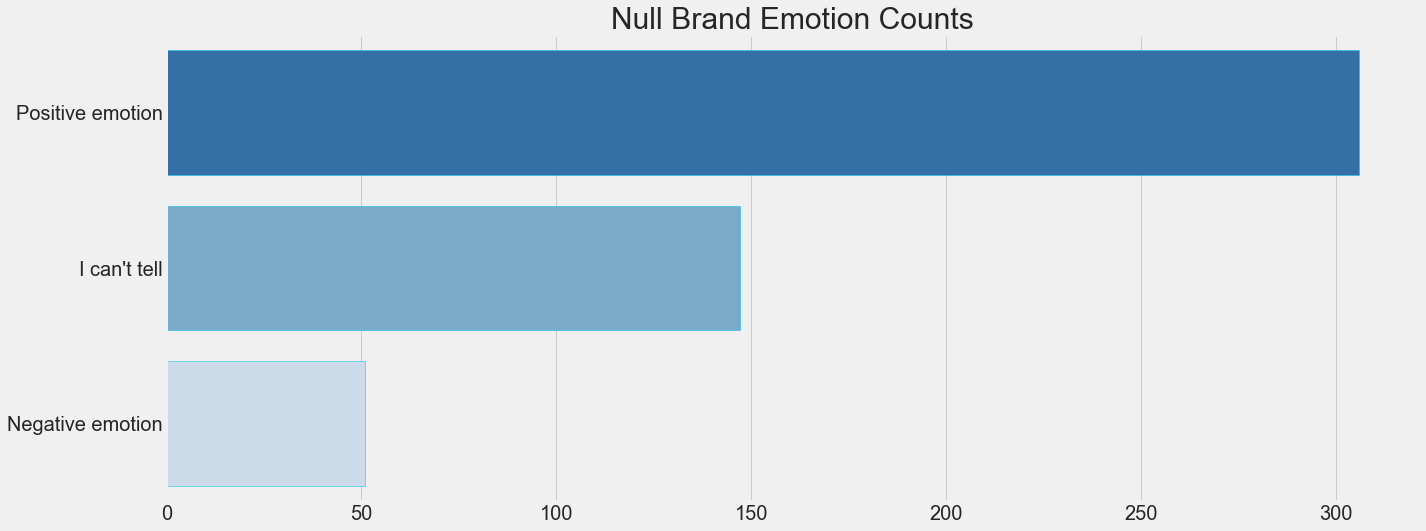

In [25]:
vz.null_brand_emotions(df)

## Filtering for Binary Emotion Data
The model will be trained to classify positive and negative sentiments.

In [26]:
df['emotion'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [40]:
binary_data = df[(df['emotion'] == 'Positive emotion') |\
                 (df['emotion'] == 'Negative emotion')].copy()

In [41]:
binary_data.reset_index(drop=True, inplace=True)

In [42]:
binary_data.head()

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [43]:
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          3548 non-null   object
 1   brand_product  3191 non-null   object
 2   emotion        3548 non-null   object
dtypes: object(3)
memory usage: 83.3+ KB


In [44]:
binary_data.isna().sum()

tweet              0
brand_product    357
emotion            0
dtype: int64

In [45]:
binary_data['emotion'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

## Binarizing Emotion Target

In [46]:
binary_data['emotion'] = binary_data['emotion'].replace(['Negative emotion'], 0)

In [47]:
binary_data['emotion'] = binary_data['emotion'].map(lambda x: 1 if x != 0 else 0)

In [49]:
binary_data['emotion'].value_counts()

1    2978
0     570
Name: emotion, dtype: int64

## Setting `data` & `target`

In [51]:
data = binary_data['tweet']
target = binary_data['emotion']

In [52]:
data.isna().sum()

0

In [53]:
target.isna().sum()

0

In [54]:
len(data)

3548

In [55]:
len(data) == len(target)

True

In [57]:
data[0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

## Testing Tokenizations

### Strategy: (stopwords, string.punctuation)

In [58]:
# removing stopwords & punx
processed_data = list(map(fn.tweet_tokens, data))

# making vocab set
vocabulary = fn.vocabulary(processed_data)

#### Checking Out Our Vocab

In [59]:
# checking number of words
len(vocabulary)

6280

In [60]:
# first 100 words
for i, val in enumerate(itertools.islice(vocabulary, 100)):
    print(val)

marty
industry
festivalgenius
entry
summer
may
iphone/ipad
joke
integration
claims
sound
costume
pic
appreciation
enjoys
81
tdg
airports
dancing
whiteboarding
notsomuch
docomo
iphone
harris
impediment
avenue
borrow
relationship
car'-use
beechwood
straight
inferior
fastcompanygrille
aquent
steady
cheer
photobooth
whowillrise
flavor
top
choose
amid
hijack
eventseekr
checkins
custome
khoi
two
checking
foing
cake
blue
ah
genius
preferences
conquered
trailer
profile
wintel
devices
view
appleaddiction
code
study
winning
weve
alive
ossum
psych
development
sloanxsw
timechange
pour
x
individuals
notionink
passport
imho
passerby
installed
stays
fb
nuts
gruber
finish
score
leave
bug
actual
learn
suck
high-fiving
harlow
crowd-curated
orly
duking
crappy
messenger
randomly
webvisions


In [61]:
# random 100 words
for i, val in enumerate(random.sample(vocabulary, 100)):
    print(val)

kik
handy
raises
forget
59
clearly
'thing'.
hangover
jessedee
figure
marketing
basics
powermat
9:30
professionals
recommendations
unite
bandwidth
screenings
brought
speller
3-d
matching
bleed
logo
stacks
meat-pointer
bulletin
battlela
ended
socialmedia
kick
image
theft
recharge
chumps
-maybe
manage
allows
flip
hmm
tweetignite
inferior
frozen
13
mypov
pac-man
totalitarian
baby
bit.ly/ajs2011
bldg
cwebb
farm
ref
appealing
buying
haha
local
plugin
austinites
wrapping
playsxswû
enter
newest
orange
tdg
cuts
uncertainty
larger
yr
poole
mill
enjoyed
-mayer
alarms
w/o
appleaddiction
michael
pair
town
surplus
worked
concierge
pour
automatically
cc
searchable
hitlantis
unstable
dream
jobsco
lightbulb
size
robot
edition
iphone.workin
length
gold
causing
kicked


### Strategy: (Regex: r'[a-zA-Z0-9]+')

In [149]:
# removing stopwords & punx
processed_data = list(map(fn.re_tokens, data))

vocabulary_re = fn.vocabulary(processed_data)

#### Checking Out Our Vocab

In [63]:
# number of words
len(vocabulary_re)

5861

In [64]:
# first 100 words
for i, val in enumerate(itertools.islice(vocabulary_re, 100)):
    print(val)

marty
industry
festivalgenius
entry
summer
may
joke
integration
claims
sound
costume
pic
appreciation
enjoys
81
tdg
airports
dancing
whiteboarding
notsomuch
docomo
iphone
harris
checkout
impediment
avenue
borrow
relationship
beechwood
crowdbeacon
straight
inferior
fastcompanygrille
aquent
steady
cheer
photobooth
whowillrise
flavor
top
choose
amid
hijack
eventseekr
checkins
custome
khoi
two
checking
foing
cake
blue
ah
genius
preferences
conquered
trailer
profile
wintel
devices
view
appleaddiction
code
study
winning
weve
alive
ossum
psych
development
sloanxsw
timechange
pour
x
individuals
notionink
passport
imho
passerby
installed
stays
fb
nuts
gruber
finish
score
leave
bug
actual
learn
suck
harlow
orly
duking
crappy
messenger
randomly
webvisions
mapped
front


In [65]:
# random 100 words
for i, val in enumerate(random.sample(vocabulary_re, 100)):
    print(val)

flew
devices
battledecks
database
magnifying
jet
un
greater
breaking
imo
problem
genius
googleio
wr
preparing
circles
flummoxed
dog
skateboards
ball
notch
andro
meaning
khoi
courtyard
tron
rather
monetization
exceptionally
behavior
4am
city
basics
emulates
brains
footnotes
83323324
200
kindle
battery
creek
graphic
realtime
instead
huge
dine
equates
intimidated
takes
sabotaged
softlayer
gogo
3k
listen
1415
cut
klick
iphones
firstworldproblems
path
guide
kickass
accommodate
desperate
bruises
movies
vb
sec
eg
collective
mid
dropping
trumping
16mins
bestie
create
pen
elevation
cuz
porting
tough
highlights
2moro
hotel
either
object
upstairs
ixd
crushit
enuf
agree
natural
replenished
customers
stranger
worth
eightbit
puts
voicefeed
years


## Lemmatizing Data

In [126]:
lemmas = fn.lemmatize(processed_data)

In [142]:
len(lemmas)

3548

In [131]:
lemmas[:5]

['wesley83 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw',
 'jessedee know fludapp awesome ipad iphone app likely appreciate design also giving free t sxsw',
 'swonderlin wait ipad 2 also sale sxsw',
 'sxsw hope year festival crashy year iphone app sxsw',
 'sxtxstate great stuff fri sxsw marissa mayer google tim reilly tech book conference amp matt mullenweg wordpress']

In [129]:
print(lemmas[0])
print(data[0])

wesley83 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.


## Stemming Data

In [140]:
stems = fn.stemmatize(processed_data)

In [141]:
len(stems)

3548

In [143]:
stems[:5]

['wesley83 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw',
 'jessede know fludapp awesom ipad iphon app like appreci design also give free ts sxsw',
 'swonderlin wait ipad 2 also sale sxsw',
 'sxsw hope year festiv crashi year iphon app sxsw',
 'sxtxstate great stuff fri sxsw marissa mayer googl tim reilli tech book confer amp matt mullenweg wordpress']

In [144]:
print(stems[0])
print(data[0])

wesley83 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.


## Stem versus Lemm

In [153]:
for i in range(10):
    print(f'stem: {stems[i]}')
    print(f'lemm: {lemmas[i]} \n')

stem: wesley83 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw
lemm: wesley83 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw 

stem: jessede know fludapp awesom ipad iphon app like appreci design also give free ts sxsw
lemm: jessedee know fludapp awesome ipad iphone app likely appreciate design also giving free t sxsw 

stem: swonderlin wait ipad 2 also sale sxsw
lemm: swonderlin wait ipad 2 also sale sxsw 

stem: sxsw hope year festiv crashi year iphon app sxsw
lemm: sxsw hope year festival crashy year iphone app sxsw 

stem: sxtxstate great stuff fri sxsw marissa mayer googl tim reilli tech book confer amp matt mullenweg wordpress
lemm: sxtxstate great stuff fri sxsw marissa mayer google tim reilly tech book conference amp matt mullenweg wordpress 

stem: sxsw start ctia around corner googleio hop skip jump good time android fan
lemm: sxsw starting ctia around corner googleio hop skip jump good time android fan 

stem: beauti smart simp

## Splitting Emotions

In [104]:
bin_positive = binary_data[binary_data['emotion']==1]
bin_negative = binary_data[binary_data['emotion']==0]

In [105]:
df_positive = bin_positive['tweet']
df_negative = bin_negative['tweet']

In [106]:
process_pos = list(map(fn.re_tokens, df_positive))
vocab_re_pos = fn.vocabulary(process_pos)
len(vocab_re_pos)

5027

In [108]:
process_neg = list(map(fn.re_tokens, df_negative))
vocab_re_neg = fn.vocabulary(process_neg)
len(vocab_re_neg)

2041